### Common utilities and imports

Copied from 2020

In [1]:
import requests
import logging
import re
from functools import lru_cache
from itertools import permutations, combinations, chain, cycle, product, islice
import networkx as nx
import collections
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import copy
import os
from aocd import get_data, submit

logger = logging.getLogger()
logger.setLevel(level=logging.INFO)

def get_ready():
    d = get_data(block=True)
    print(d)
    return d
        
## general utils
# a default dict that passes the key to the default_factory
class keydefaultdict(collections.defaultdict):
    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        else:
            ret = self[key] = self.default_factory(key)
            return ret

## plotting tools
# plot an iterable of (x, y)
def plot_xy_list(it):
    coords = np.array(list(it))
    origin = np.min(coords, axis=0)
    coords -= origin
    grid = np.full(np.max(coords, axis=0) + 1, 0)
    grid[tuple(coords.T)] = 1
    return plt.imshow(grid.T)
    
def nx_draw(G):
    layout = nx.circular_layout(G)
    nx.draw(G, pos=layout, with_labels=True, node_color='#ffdddd')
    plt.show()

class Direction(object):
    N = 0
    E = 1
    S = 2
    W = 3
    NE = 4
    SE = 5
    SW = 6
    NW = 7
    DIRS = [
        (0, -1),
        (1, 0),
        (0, 1),
        (-1, 0),
        (1, -1),
        (1, 1),
        (-1, 1),
        (-1, -1)
    ]
    @staticmethod
    def from_string(s):
        return ['N', 'E', 'S', 'W', 'NE', 'SE', 'SW', 'NW'].index(s)
    
class Marker(object):
    def __init__(self, pos, facing=Direction.N):
        self.pos = pos
        self.facing = facing
    def relative_pos(self, direction, units=1):
        delta = Direction.DIRS[direction]
        return (self.pos[0] + delta[0] * units, self.pos[1] + delta[1] * units)
    def move(self, direction=None, units=1):
        if direction is None:
            direction = self.facing
        self.pos = self.relative_pos(direction, units)
        return self.pos
    def turn_left(self):
        self.facing -= 1
        self.facing %= 4
    def turn_right(self):
        self.facing += 1
        self.facing %= 4
    def adjacent(self):
        return [self.relative_pos(d) for d in range(4)]
    def adjdiag(self):
        for dx, dy in Direction.DIRS:
            yield (self.pos[0] + dx, self.pos[1] + dy)

    
class Field(object):
    def __init__(self, data, force_width=None):
        try:
            self.field = data.split('\n')
        except:
            self.field = data.decode('ascii').split('\n')
        if force_width:
            self.width = force_width
        else:
            self.width = len(self.field[0])        
        self.field = [ r + ' ' * (self.width - len(r)) for r in self.field ]
        self.field = [ list(r) for r in self.field ]
        self.height = len(self.field)
        self.markers = []
        
    def clone(self):
        f = Field('')
        f.field = copy.deepcopy(self.field)
        f.width = self.width
        f.height = self.height
        # TODO markers
        return f
    
    def dump(self):
        print(self.raw)
    
    @staticmethod
    def from_day(day):
        return Field(get_input(day))
    
    @staticmethod
    def from_numpy(arr):
        f = Field('')
        f.field = arr.tolist()
        f.width = len(f.field[0])
        f.height = len(f.field)
        return f
        
    @property
    def raw(self):
        return '\n'.join(''.join([str(c) for c in r]) for r in self.field)
        
    def add_marker(self, marker):
        self.markers.append(marker)
        
    def get(self, x, y, oob_none=False):
        if x < 0 or y < 0 or x >= self.width or y >= self.height:
            if oob_none:
                return None
            raise KeyError('(%d:%d): out of bounds! [%dx%d]' % (x, y, self.width, self.height))
        return self.field[y][x]
    
    def set(self, x, y, v):
        self.field[y][x] = v
    
    def find(self, v):
        for y in range(self.height):
            for x in range(self.width):
                if self.get(x, y) == v:
                    yield (x, y)

    def iterate(self):
        for y in range(self.height):
            for x in range(self.width):
                yield (x, y), self.get(x, y)
                
    def iterate_marker(self):
        for y in range(self.height):
            for x in range(self.width):
                yield Marker((x, y))
                
    @property
    def numpy(self):
        return np.array(self.field)
    
    @property
    def df(self):
        return pd.DataFrame(self.numpy)
    
    def plot(self, key_fn=None):        
        if key_fn is None:
            mapping = { v: i for (i, v) in enumerate(np.unique(self.numpy)) }
            key_fn = lambda x: mapping[x]
            logging.info('Using default key_fn: %s', mapping)
        mapped = np.vectorize(key_fn)(self.numpy)
        if len(self.markers) > 0:
            marker_key = np.max(mapped) + 1
            for m in self.markers:
                mapped[m.pos[1]][m.pos[0]] = marker_key
                marker_key += 1            
        plt.imshow(mapped)
        
    def nx_maze(self, is_wall_fn=lambda t: t == '#'):
        G = nx.grid_2d_graph(f.width, f.height)
        for pos, t in self.iterate():
            if is_wall_fn(t):
                G.remove_node(pos)
        return G
    
# consider implementing a generalised dijkstras algorithm where you only need to implement
# (i) a State object that is hashable
# (ii) a get_next_states(priority, state) function that returns another list of (priority, state)
# (iii) a is_solved(state) function that returns boolean
# and run with solve(initial_state) to return lowest 
from queue import PriorityQueue
from dataclasses import dataclass, field as dcfield
from typing import Any, Callable, Generator

@dataclass(order=True)
class PrioritizedState:
    distance: int
    state: Any=dcfield(compare=False)
    def __hash__(self):
        return hash(self.state)
    def __eq__(self, other):
        return self.state == other.state

def dijkstra(initial_state: PrioritizedState, 
             get_next: Callable[[PrioritizedState], Generator[PrioritizedState, None, None]], 
             is_solved: Callable[[PrioritizedState], bool]) -> Generator[PrioritizedState, None, None]:
    queue = PriorityQueue()
    visited = set()
    queue.put(PrioritizedState(0, initial_state))
    
    while True:
        if queue.empty():
            logging.warning('no more states to try')
            break
        ps = queue.get()
        if ps in visited:
            continue
        visited.add(ps)
        if is_solved(ps):
            logging.info('solution found after visitng %d', len(visited))
            yield ps
        for ns in get_next(ps):
            queue.put(ns)

# Day 1: sliding windows

Really need to get familiar with itertools if I want to be competitive :|

In [31]:
from aocd import numbers
from more_itertools import sliding_window
sum([a < b for a, b in sliding_window(numbers, 2)])

1154

In [42]:
sum([a < b for a, b in sliding_window([a + b + c for a, b, c in sliding_window(numbers, 3)], 2)])

1127

# Day 2: simple parsing

Yay, top 100 for the first time in a looong time

In [57]:
from aocd import lines
pos = 0
depth = 0
for l in lines:
    op, val = l.split(' ')
    v = int(val)
    if op == 'forward':
        pos += v
    if op == 'down':
        depth += v
    if op == 'up': 
        depth -= v
pos * depth

1693300

In [58]:
from aocd import lines
pos = 0
depth = 0
aim = 0
for l in lines:
    op, val = l.split(' ')
    v = int(val)
    if op == 'forward':
        pos += v
        depth += aim * v
    if op == 'down':
        aim += v
    if op == 'up': 
        aim -= v
pos * depth

1857958050

# Day 3

Had to run team social so didn't attempt part 2 until afterwards.

Should remember `int(num, 2)` is how to convert binary to decimal.

In [104]:
from aocd import lines

def count(nums, i):
    ones = len([num[i] for num in nums if num[i] == '1'])
    return len(nums) - ones, ones

# get all the counts for zeroes, ones for each digit
counts = [count(lines, i) for i in range(len(lines[0]))]

binary = ''.join(['1' if ones > zeroes else '0' for zeroes, ones in counts])
gamma_rate = int(binary, 2)

binary = ''.join(['0' if ones > zeroes else '1' for zeroes, ones in counts])
epsilon_rate = int(binary, 2)

gamma_rate * epsilon_rate

3882564

In [120]:
def filter_matching(digit, offset, nums):
    if len(nums) == 1:
        return nums
    return [n for n in nums if n[offset] == digit]

ox_nums = lines[:]
co2_nums = lines[:]
for offset in range(len(lines[0])):
    zeroes, ones = count(ox_nums, offset)
    ox_nums = filter_matching('1' if ones >= zeroes else '0', offset, ox_nums)
    zeroes, ones = count(co2_nums, offset)
    co2_nums = filter_matching('0' if ones >= zeroes else '1', offset, co2_nums)

int(ox_nums[0], 2) * int(co2_nums[0], 2)

3385170

# Day 4: Bingo

Can only start late at night on Saturdays, won't be competitive :(

My cleaned up code ended up being more verbose than my original =_=

In [122]:
!date # start time

Sat Dec  4 21:06:47 AEDT 2021


In [243]:
from aocd import lines
draws = [int(n) for n in lines.pop(0).split(',')]
boards = []
board_num = -1
for l in lines:
    if l == '':
        # new board
        board_num += 1
        boards.append([])
    else:
        nums = [int(n) for n in re.split('\s+', l.strip())]
        boards[board_num].append(nums)
        
class BingoBoard(object):
    def __init__(self, rows):
        self.rows = np.array(rows)
    def draw(self, num):
        for y, row in enumerate(self.rows):
            for x, cell in enumerate(row):
                if cell == num:
                    self.rows[y][x] = 0
    def bingo(self):
        # horiz
        for row in self.rows:
            if sum(row) == 0:
                return True
        # vert
        for col in range(5):
            if sum([row[col] for row in self.rows]) == 0:
                return True
        # diags
        if sum([self.rows[i][i] for i in range(5)]) == 0:
            return True
        if sum([self.rows[i][4-i] for i in range(5)]) == 0:
            return True
    def score(self):
        return sum([sum(r) for r in self.rows])
        
def part1():
    bingo_boards = [BingoBoard(b) for b in boards]
    for draw in draws:
        for b in bingo_boards:
            b.draw(draw)
            if b.bingo():
                print(b.score() * draw)
                return
part1()

16674


In [244]:
def part2():
    bingo_boards = [BingoBoard(b) for b in boards]
    for draw in draws:
        for b in bingo_boards:
            b.draw(draw)
            if b.bingo():
                if len(bingo_boards) == 1:
                    print(b.score() * draw)
                    return
        bingo_boards = [b for b in bingo_boards if not b.bingo()]
part2()

7075


# Day 5: Slow brain day

Did not read question properly for part 1, then took me waaay too long to figure out get_points_between() for part 2

In [337]:
from aocd import lines
from collections import Counter

def get_points_between(x0, y0, x1, y1, part1=True):
    if x0 == x1 or y0 == y1:
        # horiz
        x0, x1 = sorted([x0, x1])
        y0, y1 = sorted([y0, y1])
        for x in range(x0, x1 + 1):
            for y in range(y0, y1 + 1):
                yield x, y
    else:
        if part1:
            return
        # diags
        if y0 > y1:
            # flip the points so yy0 is always the higher one
            xx0, yy0 = x1, y1
            xx1, yy1 = x0, y0
        else:
            xx0, yy0 = x0, y0
            xx1, yy1 = x1, y1
        gradient = (yy1 - yy0) / (xx1 - xx0)
        for i, y in enumerate(range(yy0, yy1 + 1)):
            x = int(xx0 + gradient * i)
            yield x, y

points = Counter()
points2 = Counter()
for l in lines:
    pt0, pt1 = re.split(' -> ', l)
    x0,y0 = [int(n) for n in pt0.split(',')]
    x1,y1 = [int(n) for n in pt1.split(',')]
    for x,y in get_points_between(x0, y0, x1, y1, part1=True):
        points[(x, y)] += 1
    for x,y in get_points_between(x0, y0, x1, y1, part1=False):
        points2[(x, y)] += 1
print('part 1', sum([1 for point in points if points[point] > 1]))
print('part 2', sum([1 for point in points2 if points2[point] > 1]))

part 1 5632
part 2 22213


# Day 6

I spent too long thinking there must be a pure math way of solving this before realising the bruteforce but optimised grouping to reduce operations was the way to go.

In [357]:
# part 1, unoptimised
data = get_data(day=6)
fishes = [int(n) for n in data.split(',')]

def tick(fishes):
    nxt = []
    new = 0
    for f in fishes:
        if f == 0:
            nxt.append(6)
            new += 1
        else:
            nxt.append(f - 1)
    for n in range(new):
        nxt.append(8)

    return nxt

for n in range(80):
    fishes = tick(fishes)
len(fishes)

377263

In [373]:
# part 2, we group number of fishes by age in cycle
from collections import Counter
fishes = [int(x) for x in data.split(',')]
ages = Counter(fishes)

def tick(ages):
    nxt = Counter()
    # cycle fishes at age 0 to 6
    nxt[6] = ages[0]
    # add new fishes at age 8 for any fishes giving birth
    nxt[8] = ages[0]
    # decrement the age of fishes
    for age in range(8):
        nxt[age] += ages[age + 1]
    return nxt

for n in range(256):
    ages = tick(ages)
sum(ages.values())

1695929023803

# Day 7

This time a pure math solution would've helped =_=

In [410]:
from aocd import lines
crabs = [int(n) for n in lines[0].split(',')]

# just bruteforce it, try every number from min to max
min([sum([abs(c - crab) for crab in crabs]) for c in range(min(crabs), max(crabs))])

336701

In [412]:
# googling "number sequence 1 3 6 10" + "formula for nth triangular numbers"
def triang_num(n):
    return int((n * (n + 1)) / 2)

min([sum([triang_num(abs(c - crab)) for crab in crabs]) for c in range(min(crabs), max(crabs))])

95167302

# Day 8

It ain't pretty, but solved by treating it like a puzzle rather than coding exercise.

Learnings: `frozenset()`s are hashable

In [464]:
from aocd import lines

count = 0
for line in lines:
    signal, output = line.split('|')
    chunks = output.strip().split(' ')
    #                                             1  4  7  8
    count += len([c for c in chunks if len(c) in [2, 4, 3, 7]])
count

543

In [486]:
# first figure out unique counts for each segment
segments = [
    'abcefg',
    'cf',
    'acdeg',
    'acdfg',
    'bcdf',
    'abdfg',
    'abdefg',
    'acf',
    'abcdefg',
    'abcdfg',
]
Counter(''.join(segments))

# it looks like 4 6 9 are unique
# e is used in 4 digits
# b is used in 6 digits
# f is used in 9 digits

Counter({'a': 8, 'b': 6, 'c': 8, 'e': 4, 'f': 9, 'g': 7, 'd': 7})

In [487]:
# solve based on
#
#  aaaa
# b    c
# b    c
#  dddd
# e    f
# e    f
#  gggg
#
# returns a dict of frozenset(segments) -> digit
def solve(signals):
    solution = {}
    counter = Counter()
    # first pass, do the easy digits
    for c in signals:
        l = len(c)
        if l == 2:
            solution[1] = set(c)
        elif l == 4:
            solution[4] = set(c)
        elif l == 3:
            solution[7] = set(c)
        elif l == 7:
            solution[8] = set(c)
        for cc in c:
            counter[cc] += 1
    # use counter to derive e, b, f
    e = set([k for k in counter if counter[k] == 4])
    b = set([k for k in counter if counter[k] == 6])
    f = set([k for k in counter if counter[k] == 9])
    # then use what we know to figure out the remaining digits/segments
    a = solution[7] - solution[1]
    c = solution[1] - f
    # we can derive all the numbers easily now
    solution[6] = solution[8] - c    
    solution[5] = solution[6] - e
    solution[9] = solution[8] - e
    solution[3] = solution[8] - e - b
    solution[2] = solution[8] - b - f
    # for zero it's just the last remaining signal
    solution[0] = next(set(sig) for sig in signals if set(sig) not in solution.values())
    # invert the solution so the keys are the segment set
    return {frozenset(v): k for k,v in solution.items()}

t = 0
for line in lines:
    signal, output = line.split('|')
    soln = solve(signal.strip().split(' '))
    t += int(''.join(str(soln[frozenset(out)]) for out in output.strip().split(' ')))
t

994266

# Day 9: Field utility finally comes in handy

And I've forgotten all about the API..

INFO:aocd.get:most recent year=2021
INFO:root:Using default key_fn: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


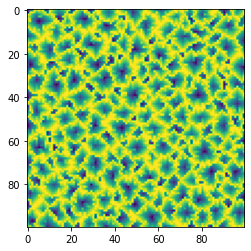

In [530]:
f = Field(get_data(day=9))
f.plot()

In [504]:
risk = 0
for (x, y), h in f.iterate():
    marker = Marker((x, y))
    # low point is any point lower than adjacent
    is_low = True
    for x0, y0 in marker.adjacent():
        try:
            h0 = f.get(x0, y0)
            if int(h0) <= int(h):
                is_low = False
                break
        except KeyError:
            pass
    if is_low:
        risk += (int(h) + 1)
risk

548

In [529]:
checked = set()
basin_sizes = []

def fill_basin_at(x, y):
    basin = 0
    try:
        if (x, y) in checked:
            return 0
        h = int(f.get(x, y))
        if h == 9:
            checked.add((x, y))        
            return 0
        point = Marker((x, y))
        checked.add((x, y))
        for x0, y0 in point.adjacent():
            basin += fill_basin_at(x0, y0)
        return 1 + basin
    except KeyError as e:
        checked.add((x, y))
        return 0
    
for (x, y), h in f.iterate():
    b = fill_basin_at(x, y)
    if b > 0:
        basin_sizes.append(b)
        
np.prod(sorted(basin_sizes)[-3:])

786048

# Day 10: Stacks

I was feeling pretty dead after ShipIt

I had to look up how to pop values from a list ><

In [575]:
def check(line):
    stack = []
    for c in line:
        if c in '({<[':
            stack.append(c)
        else:
            if c == ')':
                if stack[-1] != '(':
                    return 3
                stack.pop()
            if c == ']':
                if stack[-1] != '[':
                    return 57
                stack.pop()
            if c == '}':
                if stack[-1] != '{':
                    return 1197
                stack.pop()
            if c == '>':
                if stack[-1] != '<':
                    return 25137
                stack.pop()
    return 0
lines = get_data(day=10).split('\n')
sum([check(l) for l in lines])

INFO:aocd.get:most recent year=2021


339411

In [576]:
incomplete = [line for line in lines if check(line) == 0]

def complete_line(line):
    stack = []
    total_score = 0
    for c in line:
        if c in '({<[':
            stack.append(c)
        else:
            stack.pop()
    while stack:
        c = stack.pop()
        total_score *= 5
        if c == '(':
            total_score += 1
        if c == '[':
            total_score += 2
        if c == '{':
            total_score += 3
        if c == '<':
            total_score += 4
    return total_score

int(np.median([complete_line(l) for l in incomplete]))

2289754624

# Day 11

Had a wedding and church today, quite thankful that it's just a matter of reusing my Field utility again.

In [553]:
!date # start

Sat Dec 11 22:07:51 AEDT 2021


In [578]:
f = Field(get_data(day=11))
for (x, y), v in f.iterate():
    f.set(x, y, int(v))
    
def incr(f, x, y, flashed):
    if (x, y) in flashed:
        return
    try:
        v = f.get(x, y)
    except:
        return
    if v == 9:
        f.set(x, y, 0)
        flashed.add((x, y))
        for x0, y0 in Marker((x, y)).adjdiag():
            incr(f, x0, y0, flashed)
    else:
        f.set(x, y, v + 1)

total_flashes = 0
def tick(f):
    flashed = set()
    for (x, y), v in f.iterate():
        incr(f, x, y, flashed)
    return len(flashed)
    
for _ in range(100):
    total_flashes += tick(f)
    
total_flashes

INFO:aocd.get:most recent year=2021


1644

In [579]:
f = Field(get_data(day=11))
for (x, y), v in f.iterate():
    f.set(x, y, int(v))

c = 0
while True:
    n = tick(f)
    c += 1
    if n == 100:
        break
c

INFO:aocd.get:most recent year=2021


229

In [571]:
!date #end

Sat Dec 11 22:22:07 AEDT 2021


# Day 12: pathfinding

I thought `networkx` would come in handy but it didn't really. Totally misread the question as "only one small cave is allowed per path" not "each small cave is allowed to be visited once".

In [3]:
from aocd import lines

# construct the graph
G = nx.Graph()
for l in lines:
    G.add_edge(*l.split('-'))

In [636]:
def is_small(n):
    if n == 'start' or n == 'end':
        return False
    return n == n.lower()

def get_all_paths_from(so_far, visited_small_caves):
    last_node = so_far[-1]
    for n in G.neighbors(last_node):
        if n == 'start':
            continue
        visited_copy = visited_small_caves.copy()
        if is_small(n):
            if n in visited_small_caves:
                continue
            visited_copy.add(n)
        so_far_copy = so_far[:]
        so_far_copy.append(n)
        if n == 'end':
            yield so_far_copy
        else:
            for pp in get_all_paths_from(so_far_copy, visited_copy):
                yield pp
        
        
len(list(get_all_paths_from(['start'], set())))

3421

In [675]:
%%time
def get_all_paths_from(so_far, visited_small_caves, bonus_small):
    last_node = so_far[-1]
    for n in G.neighbors(last_node):
        if n == 'start':
            continue
        visited_copy = visited_small_caves.copy()
        bonus_small_copy = bonus_small
        if is_small(n):
            if n in visited_small_caves:
                if bonus_small is not None:
                    continue
                bonus_small_copy = n
            visited_copy.add(n)
        so_far_copy = so_far[:]
        so_far_copy.append(n)
        if n == 'end':
            yield so_far_copy
        else:
            for pp in get_all_paths_from(so_far_copy, visited_copy, bonus_small_copy):
                yield pp
        
        
len(list(get_all_paths_from(['start'], set(), None)))

CPU times: user 873 ms, sys: 4.53 ms, total: 878 ms
Wall time: 879 ms


84870

In [5]:
# this cleaned up version uses my dijkstras utility, 
# though it's unnecessary as there is no weight on the paths
# it is also a lot slower than the dirty solution above
# but it's nice to be able to decompose the search problem into the
# state, get_next, is_solved parts
from aocd import lines

# construct the graph
G = nx.Graph()
for l in lines:
    G.add_edge(*l.split('-'))
    
@dataclass
class State:
    path: list
    def __hash__(self):
        return hash(','.join(self.path))
    
# returns all next-step paths which satisfy the conditions
def get_next(p: PrioritizedState):
    last_node = p.state.path[-1]
    for adj_node in G.neighbors(last_node):
        if adj_node == 'start':
            continue
        path_copy = p.state.path[:]
        if adj_node.lower() == adj_node:
            if adj_node in p.state.path:
                continue
        path_copy.append(adj_node)
        yield PrioritizedState(0, State(path_copy))
        
def is_solved(p: PrioritizedState):
    return p.state.path[-1] == 'end'

len(list(dijkstra(State(['start']), get_next, is_solved)))

3421

In [6]:
%%time

logger = logging.getLogger()
logger.setLevel(level=logging.WARN)

@dataclass
class State:
    path: list
    bonus_cave: str
    def __hash__(self):
        return hash(','.join(self.path))
    
# returns all next-step paths which satisfy the conditions
def get_next(p: PrioritizedState):
    last_node = p.state.path[-1]
    if last_node == 'end':
        return
    for adj_node in G.neighbors(last_node):
        if adj_node == 'start':
            continue
        path_copy = p.state.path[:]
        bonus_cave_copy = p.state.bonus_cave
        if adj_node.lower() == adj_node:
            if adj_node in p.state.path:
                # if we don't have a bonus cave yet, assign it
                if p.state.bonus_cave is not None:
                    continue
                bonus_cave_copy = adj_node
        path_copy.append(adj_node)
        yield PrioritizedState(0, State(path_copy, bonus_cave_copy))
        
# slightly wrong because 'end' is not terminating
len(list(dijkstra(State(['start'], None), get_next, is_solved)))

CPU times: user 7.35 s, sys: 145 ms, total: 7.5 s
Wall time: 7.55 s


84870

# Day 13: yay to plotting utils

INFO:aocd.get:most recent year=2021
INFO:aocd.get:most recent year=2021


part1 610
part2


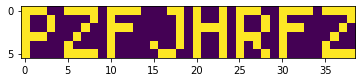

In [78]:
def fold_x(dots, num):
    folded = set()
    for (x, y) in dots:
        if x > num:
            new_x = num - (x - num)
            folded.add((new_x, y))
        else:
            folded.add((x, y))
    return folded

def fold_y(dots, num):
    folded = set()
    for (x, y) in dots:
        if y > num:
            new_y = num - (y - num)
            folded.add((x, new_y))
        else:
            folded.add((x, y))
    return folded

dots = set()
for l in get_data(day=13).split('\n'):
    if l == '':
        break
    x, y = [int(n) for n in l.split(',')]
    dots.add((x, y))

# part 1
print('part1', len(fold_x(dots, 655)))

for l in get_data(day=13).split('\n'):
    m = re.match(r'fold along (x|y)=(\d+)', l)
    if m:
        axis, num = m.groups()
        num = int(num)
        if axis == 'x':
            dots = fold_x(dots, num)
        else:
            dots = fold_y(dots, num)

print('part2')
plot_xy_list(dots)

INFO:aocd.get:most recent year=2021
INFO:aocd.get:most recent year=2021
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 400x200 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/ll/8prdsyld7b56_wmddwxvmth00000gn/T/tmphzjl7y2a/temp.m4v


CPU times: user 450 ms, sys: 59.6 ms, total: 510 ms
Wall time: 564 ms


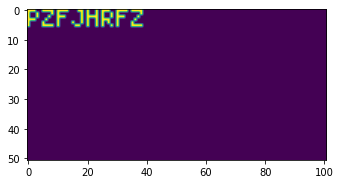

In [71]:
%%time
# fun with matplotlib animations - just refreshing old memories of how to do this
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

dots = set()
for l in get_data(day=13).split('\n'):
    if l == '':
        break
    x, y = [int(n) for n in l.split(',')]
    dots.add((x, y))

def get_frames(dots):
    frames = []
    for l in get_data(day=13).split('\n'):
        m = re.match(r'fold along (x|y)=(\d+)', l)
        if m:
            axis, num = m.groups()
            num = int(num)
            if axis == 'x':
                dots = fold_x(dots, num)
            else:
                dots = fold_y(dots, num)
            frames.append(dots.copy())
    return frames

bounds = np.array([100, 50])

def get_grid(xy_list):
    coords = np.array([(x, y) for (x, y) in xy_list if x < bounds[0] and y < bounds[1]])
    origin = np.min(coords, axis=0)
    coords -= origin
    grid = np.full(bounds + 1, 0)
    grid[tuple(coords.T)] = 1
    return grid.T

fig = plt.figure()
fig.set_size_inches(bounds[0] * 4 / fig.dpi, bounds[1] * 4 / fig.dpi)
im = plt.imshow(get_grid(dots), animated=True)
plt.imshow

def updatefig(dots):
    try:
        im.set_array(get_grid(dots))
    except:
        pass
    return im,

ani = animation.FuncAnimation(fig, updatefig, frames=get_frames(dots), interval=200, blit=False)
HTML(ani.to_html5_video())

2

B

Ea

 



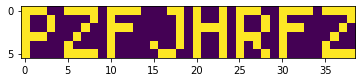

In [96]:
# pytesseract OCR test - it sucks for this plot output
import io
from PIL import Image
import pytesseract

plt.figure()
img = plot_xy_list(dots)

img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')

im = Image.open(img_buf)
s = pytesseract.image_to_string(im)
print(s)
img_buf.close()

# Day 14: tricky pairs

I had a bug for ages where I wasn't counting the pairs in the initial input properly

In [240]:
# inefficient part 1
from more_itertools import sliding_window
from aocd import lines
from collections import Counter
template = lines.pop(0)
lines.pop(0)
insertions = {}
for l in lines:
    src, dst = l.split(' -> ')
    insertions[src] = dst
    
def step(template):
    nxt = []
    for pair in sliding_window(template, 2):
        xy = ''.join(pair)
        if xy in insertions:
            nxt.append(pair[0])
            nxt.append(insertions[xy])
        else:
            nxt.append(pair[0])
    nxt.append(pair[1])
    return ''.join(nxt)

t = template
for i in range(10):
    t = step(t)
    
ct = Counter(t)
max(ct.values()) - min(ct.values())

3406

In [241]:
# for this part the trick is that when AB -> ACB, effectively 
# you now have AC, CB and you can derive from this how many pairs
# of letters you'll have at the end by keeping track of pairs
from more_itertools import sliding_window
from aocd import lines
from collections import Counter

template = lines.pop(0)
lines.pop(0)
insertions = {}
for l in lines:
    src, dst = l.split(' -> ')
    insertions[src] = dst

num_pairs = Counter([''.join(pair) for pair in sliding_window(template, 2)])

def step(num_pairs):
    new_pairs = num_pairs.copy()
    # expand all the pairs we know of
    for pair in num_pairs:
        if pair in insertions:
            new_pair0 = pair[0] + insertions[pair]
            new_pair1 = insertions[pair] + pair[1]
            new_pairs[pair] -= num_pairs[pair]
            new_pairs[new_pair0] += num_pairs[pair]
            new_pairs[new_pair1] += num_pairs[pair]
    return new_pairs

for i in range(40):
    num_pairs = step(num_pairs)
    
# finally tally up the chars, since the pairs overlap except for last char, just count the first chars then finally +1 the last char
ct = Counter()
for pair in num_pairs:
    ct[pair[0]] += num_pairs[pair]
ct[template[-1]] += 1
    
max(ct.values()) - min(ct.values())

3941782230241

# Day 15: Dijkstra fail

I tried using my old generic dijkstra utility but somehow it failed me :( something wrong with the way I implemented hashing and marking visited is not correct.

Ended up just relying on `networkx`

I also tried to optimise it with an A* search but it ended up producing wrong results =_=

In [248]:
f = Field(get_data(day=15))
for (x, y), v in f.iterate():
    f.set(x, y, int(v))
    
def find_weight(f):
    # create an nx directed graph where the edges have weight equal to the destination node
    G = nx.DiGraph()
    for (x, y), v in f.iterate():
        for (x0, y0) in Marker((x, y)).adjacent():
            v0 = f.get(x0, y0, True)
            if v0 is not None:
                G.add_edge((x, y), (x0, y0), weight=v0)
    # find the shortest path from top left to bottom right by weight
    return nx.shortest_path_length(G, (0, 0), (f.width - 1, f.height - 1), weight='weight')
    
find_weight(f)

811

In [249]:
%%time

# construct the 5x field
f2 = Field.from_numpy(np.empty([f.width * 5, f.height * 5]))
for (x, y), v in f.iterate():
    for wx in range(5):
        for wy in range(5):
            wrapped_v = (v + wx + wy - 1) % 9 + 1
            f2.set(x + f.width * wx, y + f.height * wy, wrapped_v)      
            
find_weight(f2)

CPU times: user 5.63 s, sys: 189 ms, total: 5.82 s
Wall time: 5.82 s


3012

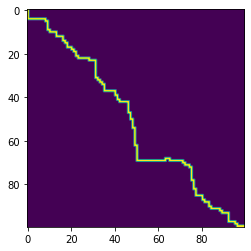

In [7]:
f = Field(i)
for (x, y), v in f.iterate():
    f.set(x, y, int(v))
    
def find_weight(f):
    # create an nx directed graph where the edges have weight equal to the destination node
    G = nx.DiGraph()
    for (x, y), v in f.iterate():
        for (x0, y0) in Marker((x, y)).adjacent():
            v0 = f.get(x0, y0, True)
            if v0 is not None:
                G.add_edge((x, y), (x0, y0), weight=v0)
    # find the shortest path from top left to bottom right by weight
#     return nx.shortest_path_length(G, (0, 0), (f.width - 1, f.height - 1), weight='weight')
    return nx.shortest_path(G, (0, 0), (f.width - 1, f.height - 1), weight='weight')
plot_xy_list(find_weight(f))

# Day 16: advent of parsing

The problem description is _very_ confusing today. It took me the longest time understand when zero-padding occurs and when it did not. I got stumped for the longest time on missing the fact that my hex-to-bin was stripping zeroes from the front of the output.

Restarted my implemention halfway through after realising a simple loop would not suffice and there were subpackets.

Not the cleanest code, but did not enjoy today.

In [128]:
class Decoder(object):
    def __init__(self, bindata, zeropad=False):        
        if zeropad:
            zeropad = (8 - len(bindata) % 8) % 8
            self.data = list('0' * zeropad) + bindata
        else:
            self.data = bindata[:]
        self.versum = 0
        self.result = None
        
    def read_bits(self, num_bits):
        bits = []
        for i in range(num_bits):
            bits.append(self.data.pop(0))
        return bits
    def read_num(self, num_bits):
        return int(''.join(self.read_bits(num_bits)), 2)
            
    def read_next_packet(self):
        if len(self.data) == 0:
            return False
        ver = self.read_num(3)
        self.versum += ver
        tid = self.read_num(3)
        if tid == 4: # literal
            num = []
            while True:
                x = self.data.pop(0)
                for i in range(4):
                    num.append(self.data.pop(0))
                if x == '0':
                    break
            numm = int(''.join(num), 2)
            self.result = numm
        else:
            # operator
            opcode = tid
            operands = []
            if self.read_num(1) == 0:
                subpacket_bits_len = self.read_num(15)
                subpacket_bits = self.read_bits(subpacket_bits_len)
                subpacket_decoder = Decoder(subpacket_bits)
                while subpacket_decoder.read_next_packet():
                    operands.append(subpacket_decoder.result)
                    subpacket_decoder.result = None
                self.versum += subpacket_decoder.versum
            else:
                cont_packets_len = self.read_num(11)
                for i in range(cont_packets_len):
                    self.read_next_packet()
                    operands.append(self.result)
                    self.result = None                    
            self.calc_result(opcode, operands)
        return True

    def calc_result(self, opcode, operands):
        if opcode == 0:
            self.result = sum(operands)
        if opcode == 1:
            self.result = np.prod(operands)
        if opcode == 2:
            self.result = min(operands)
        if opcode == 3:
            self.result = max(operands)
        if opcode == 5:
            self.result = 1 if operands[0] > operands[1] else 0
        if opcode == 6:
            self.result = 1 if operands[0] < operands[1] else 0
        if opcode == 7:
            self.result = 1 if operands[0] == operands[1] else 0

# convert input to binary
binary = bin(int(get_data(day=16), 16))

decoder = Decoder(list(binary[2:]), True)
decoder.read_next_packet()
print(decoder.versum, decoder.result)

969 124921618408
